# Lesson 8: More Decisions

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD


<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2020_Spring/notebooks/08_More_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



## Lesson plan

- Linear Ballistic Accumulator exploration
- PDA explantion
- Model fits to data
- Model comparison


## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/decision_data.csv

In [ ]:
# to install more libraries
#!pip install plotnine
!pip install KDEpy
!pip install arviz

## Load modules

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import arviz as az

from ipywidgets import interact, fixed

#from RunDEMC.density import kdensity
from KDEpy import FFTKDE

## Load and process the data

In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)

# get rid of the neutral condition
dat = dat[dat.cond != 'Neutral']

# make a new column that combines accuracy and rt
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


In [3]:
dat.groupby(['cond', 'correct'])['rt'].mean().reset_index()


,cond,correct,rt
0,Accuracy,0,0.589848
1,Accuracy,1,0.603819
2,Speed,0,0.349665
3,Speed,1,0.379169


## What does this tell us?

- Looking at behavioral effects alone can not reveal the processes that gave rise to that choice and RT.

- i.e., if you made a specific response, we don't know *why* you made that response.

## Going Deeper: What affects your decisions? 


## Linear Ballistic Accumlator (LBA)

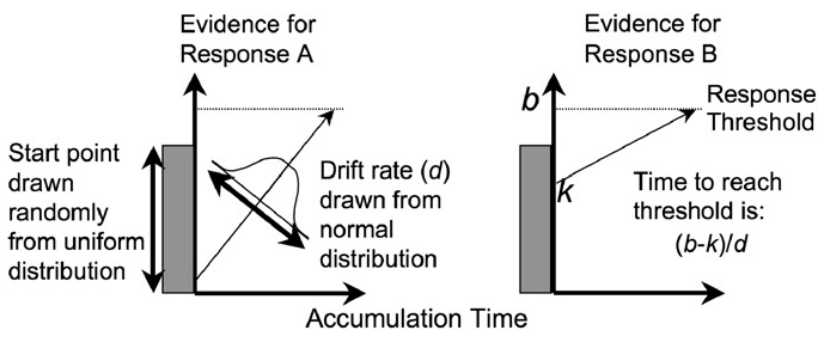

In [4]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.squeeze(np.atleast_1d(I))
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    # see where there are none above zero
    ind = np.all(d<=0.0,axis=1)
    while np.any(ind):
        d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
        ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    inds[~resp_ind] = -1
    times[~resp_ind] = -1
    
    # make a dataframe
    return pd.DataFrame({'correct': inds, 'rt': times})
    


In [5]:
# set up the sim
nsims = 5000
cond='Accuracy'
ndat = (dat['cond']==cond).sum()
plt.figure(figsize=(10,6))

# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    #p,xx = kdensity(dat, extrema=(xvals.min(),xvals.max()), xx=xvals)
    p = FFTKDE(kernel='epa', bw='silverman').fit(dat).evaluate(xvals)
    p *= float(len(dat))/nsims
    plt.plot(xvals, p, color=color, lw=2.)

# put it all together
@interact(d1=(0.0,5.0,0.05),
          d2=(0.0,5.0,0.05),
          A=(0.0,1.0,.05),
          b=(0.0,5.0,.05),
          t0=(0.0,1.0,.02),
          S=fixed(1.0)
          )
def run_lba(d1=1.0, d2=2.0, A=.1, b=1.0, t0=0.0, S=1.0):
    # run the LBA model
    res = lba_sim(I=(d1, d2), A=A, S=S, b=b, num_sims=nsims, max_time=2.0, t0=t0)
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
    #ylim(0,5.0)
    plt.xlim(0,2.0)

<Figure size 720x432 with 0 Axes>

interactive(children=(FloatSlider(value=1.0, description='d1', max=5.0, step=0.05), FloatSlider(value=2.0, des…

## Using computers to test hypotheses

In [6]:
from RunDEMC import Model, Param, dists
from RunDEMC.pda import PDA
from RunDEMC.io import arviz_dict
from RunDEMC.density import boxcox

## Fitting Decision Models

What do we do when our model doesn't have an analytical likelihood function?

PDA to the rescue!!!

In [53]:
# Test change in threshold

# set up the params
min_rt = dat.rt.min()
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]

# grab the beh data of interest
dat_A = dat[(dat['cond']=='Accuracy')].to_records()
dat_S = dat[(dat['cond']=='Speed')].to_records()

# set up PDA
rt_min = .05
rt_max = 2.1
pda_A = PDA(dat_A, cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)
pda_S = PDA(dat_S, cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)

print(pda_A._lower, pda_A._upper)
print(pda_S._lower, pda_S._upper)

# define the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b_A']) or (p['A'] > p['b_S']): # or np.any(p<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        # run the simulation
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_A'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        # convert fast responses to non-responses
        res.loc[res.rt < rt_min, 'correct'] = -1
        # calc log like via PDA
        likes[i] += pda_A.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
        # then Speed
        # run the simulation
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_S'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        # convert fast responses to non-responses
        res.loc[res.rt < rt_min, 'correct'] = -1
        # calc log like via PDA
        likes[i] += pda_S.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
    return likes
        
# make the model
m = Model('decisions', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          purify_every=5,
          pop_parallel=True,
          verbose=True)


-27.491212349279863 0.49618599732126356
-16.400884801088214 0.5357425467383643


## The PDA method

When we do not have an analytical likelihood for our model, we can simulate it many times to estimate the likelihood.

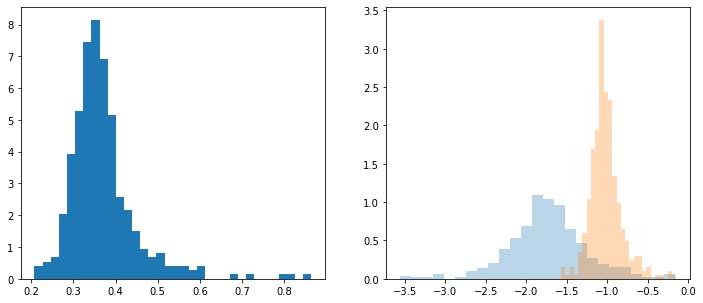

In [54]:
# explore the Box--Cox Transform
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.array(dat_S.rt), bins='auto', density=True);

plt.subplot(1,2,2)
plt.hist(boxcox(np.array(dat_S.rt), pda_S._lambdax), bins='auto', density=True, alpha=.3);
plt.hist(np.log(np.array(dat_S.rt)), bins='auto', density=True, alpha=.3);


In [47]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(500, burnin=False)


Initializing: 60(60) 18(18) 7(7) 4(4) 1(1) Iterations (100): 1 2 3 4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 26 27 28 29 = 30 31 32 33 34 = 35 36 37 38 39 = 40 41 42 43 44 = 45 46 47 48 49 = 50 51 52 53 54 = 55 56 57 58 59 = 60 61 62 63 64 = 65 66 67 68 69 = 70 71 72 73 74 = 75 76 77 78 79 = 80 81 82 83 84 = 85 86 87 88 89 = 90 91 92 93 94 = 95 96 97 98 99 = 100 
Iterations (500): 1 2 3 4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 26 27 28 29 = 30 31 32 33 34 = 35 36 37 38 39 = 40 41 42 43 44 = 45 46 47 48 49 = 50 51 52 53 54 = 55 56 57 58 59 = 60 61 62 63 64 = 65 66 67 68 69 = 70 71 72 73 74 = 75 76 77 78 79 = 80 81 82 83 84 = 85 86 87 88 89 = 90 91 92 93 94 = 95 96 97 98 99 = 100 101 102 103 104 = 105 106 107 108 109 = 110 111 112 113 114 = 115 116 117 118 119 = 120 121 122 123 124 = 125 126 127 128 129 = 130 131 132 133 134 = 135 136 137 138 139 = 140 141 142 143 144 = 145 146 147 148 149 = 150 151 152 153 154 = 155 156 157 158 15

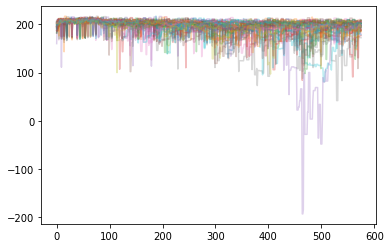

In [48]:
plt.plot(m.weights[25:], alpha=.3);

In [50]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -329.1060951543054
"d1": 1.625318,
"d2": 2.651284,
"A": 0.492396,
"b_A": 1.252677,
"b_S": 0.710610,
"t0": 0.195313,


In [12]:
# save out model to an ArviZ Inference Dataset
daz_t = az.from_dict(**arviz_dict(m, burnin=200))
daz_t.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    d1       (chain, draw) float64 3.101 3.101 3.101 3.101 ... 1.869 1.869 1.869
    d2       (chain, draw) float64 3.735 3.735 3.735 3.735 ... 2.852 2.852 2.852
    A        (chain, draw) float64 0.5256 0.5256 0.5256 ... 0.3878 0.3878 0.3878
    b_A      (chain, draw) float64 2.351 2.351 2.351 2.351 ... 1.544 1.544 1.544
    b_S      (chain, draw) float64 1.495 1.495 1.495 ... 0.9372 0.9372 0.9372
    t0       (chain, draw) float64 0.05652 0.05652 0.05652 ... 0.1089 0.1089
Attributes:
    created_at:  2020-03-11T20:13:57.769739

In [51]:
az.waic(daz_t)

/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 24060 by 1.0 log-likelihood matrix

        Estimate       SE
IC_waic  3241.11     0.00
p_waic    631.52        -

There has been a warning during the calculation. Please check the results.

/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


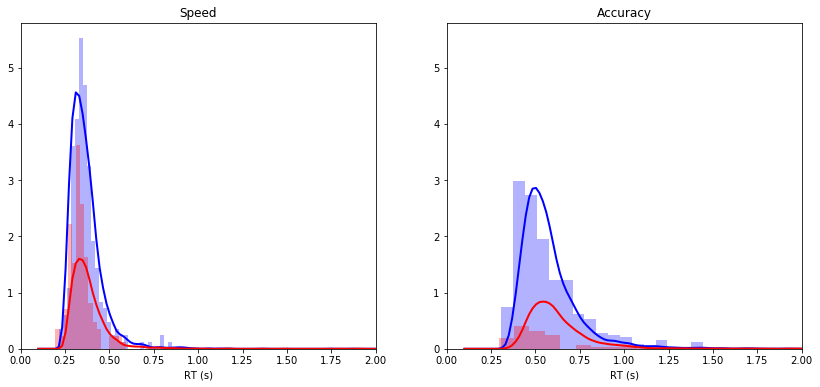

In [52]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [62]:
# Test change in drift rate

# set up the params
params = [Param(name='d1_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d1_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]


# grab the beh data of interest
dat_A = dat[(dat['cond']=='Accuracy')].to_records()
dat_S = dat[(dat['cond']=='Speed')].to_records()

# set up PDA
rt_min = .05
rt_max = 2.1
pda_A = PDA(dat_A, cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)
pda_S = PDA(dat_S, cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)

print(pda_A._lower, pda_A._upper)
print(pda_S._lower, pda_S._upper)

# set up the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b']): # or np.any(p<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p['d1_A'], p['d2_A']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        res.loc[res.rt < rt_min, 'correct'] = -1
        likes[i] += pda_A.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
        # then Speed
        res = lba_sim(I=(p['d1_S'], p['d2_S']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        res.loc[res.rt < rt_min, 'correct'] = -1
        likes[i] += pda_S.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue

    return likes
        
# make the model
m = Model('decisions2', params=params,
          like_fun=like_fun,
          like_args=(dat,),
          purify_every=5,
          verbose=True)


-27.491212349279863 0.49618599732126356
-16.400884801088214 0.5357425467383643


In [63]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(500, burnin=False)


Initializing: 70(70) 13(13) 1(1) Iterations (100): 1 2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


4 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 5 6 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


7 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


8 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


9 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 10 11 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


12 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


13 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


14 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 15 16 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


17 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


18 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


19 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 20 21 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


22 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


23 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


24 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 25 26 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


27 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


28 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


29 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 30 31 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


32 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


33 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


34 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 35 36 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


37 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


38 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


39 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 40 41 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


42 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


43 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


44 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 45 46 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


47 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


48 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


49 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 50 51 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


52 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


53 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


54 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 55 56 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


57 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


58 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


59 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 60 61 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


62 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


63 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


64 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 65 66 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


67 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


68 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


69 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 70 71 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


72 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


73 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


74 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 75 76 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


77 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


78 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


79 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 80 81 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


82 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


83 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


84 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 85 86 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


87 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


88 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


89 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 90 91 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


92 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


93 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


94 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 95 96 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


97 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


98 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


99 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 100 
Iterations (500): 1 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


4 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 5 6 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


7 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


8 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


9 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 10 11 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


12 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


13 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


14 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 15 16 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


17 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


18 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


19 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 20 21 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


22 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


23 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


24 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 25 26 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


27 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


28 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


29 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 30 31 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


32 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


33 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


34 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 35 36 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


37 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


38 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


39 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 40 41 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


42 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


43 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


44 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 45 46 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


47 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


48 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


49 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 50 51 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


52 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


53 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


54 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 55 56 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


57 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


58 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


59 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 60 61 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


62 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


63 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


64 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 65 66 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


67 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


68 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


69 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 70 71 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


72 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


73 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


74 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 75 76 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


77 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


78 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


79 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 80 81 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


82 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


83 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


84 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 85 86 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


87 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


88 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


89 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 90 91 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


92 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


93 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


94 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 95 96 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


97 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


98 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


99 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 100 101 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


102 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


103 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


104 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 105 106 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


107 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


108 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


109 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 110 111 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


112 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


113 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


114 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 115 116 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


117 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


118 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


119 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 120 121 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


122 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


123 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


124 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 125 126 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


127 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


128 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


129 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 130 131 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


132 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


133 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


134 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 135 136 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


137 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


138 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


139 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 140 141 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


142 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


143 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


144 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 145 146 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


147 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


148 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


149 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 150 151 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


152 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


153 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


154 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 155 156 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


157 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


158 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


159 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 160 161 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


162 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


163 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


164 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 165 166 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


167 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


168 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


169 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 170 171 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


172 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


173 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


174 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 175 176 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


177 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


178 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


179 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 180 181 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


182 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


183 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


184 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 185 186 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


187 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


188 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


189 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 190 191 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


192 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


193 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


194 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 195 196 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


197 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


198 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


199 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 200 201 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


202 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


203 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


204 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 205 206 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


207 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


208 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


209 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 210 211 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


212 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


213 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


214 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 215 216 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


217 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


218 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


219 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 220 221 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


222 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


223 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


224 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 225 226 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


227 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


228 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


229 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 230 231 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


232 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


233 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


234 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 235 236 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


237 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


238 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


239 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 240 241 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


242 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


243 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


244 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 245 246 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


247 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


248 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


249 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 250 251 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


252 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


253 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


254 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 255 256 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


257 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


258 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


259 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 260 261 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


262 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


263 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


264 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 265 266 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


267 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


268 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


269 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 270 271 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


272 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


273 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


274 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 275 276 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


277 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


278 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


279 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 280 281 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


282 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


283 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


284 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 285 286 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


287 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


288 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


289 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 290 291 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


292 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


293 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


294 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 295 296 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


297 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


298 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


299 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 300 301 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


302 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


303 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


304 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 305 306 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


307 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


308 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


309 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 310 311 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


312 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


313 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


314 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 315 316 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


317 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


318 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


319 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 320 321 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


322 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


323 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


324 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 325 326 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


327 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


328 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


329 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 330 331 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


332 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


333 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


334 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 335 336 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


337 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


338 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


339 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 340 341 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


342 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


343 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


344 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 345 346 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


347 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


348 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


349 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 350 351 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


352 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


353 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


354 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 355 356 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


357 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


358 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


359 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 360 361 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


362 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


363 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


364 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 365 366 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


367 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


368 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


369 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 370 371 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


372 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


373 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


374 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 375 376 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


377 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


378 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


379 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 380 381 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


382 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


383 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


384 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 385 386 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


387 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


388 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


389 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 390 391 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


392 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


393 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


394 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 395 396 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


397 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


398 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


399 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 400 401 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


402 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


403 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


404 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 405 406 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


407 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


408 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


409 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 410 411 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


412 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


413 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


414 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 415 416 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


417 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


418 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


419 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 420 421 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


422 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


423 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


424 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 425 426 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


427 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


428 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


429 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 430 431 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


432 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


433 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


434 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 435 436 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


437 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


438 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


439 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 440 441 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


442 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


443 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


444 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 445 446 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


447 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


448 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


449 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 450 451 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


452 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


453 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


454 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 455 456 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


457 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


458 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


459 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 460 461 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


462 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


463 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


464 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 465 466 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


467 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


468 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


469 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 470 471 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


472 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


473 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


474 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 475 476 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


477 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


478 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


479 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 480 481 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


482 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


483 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


484 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 485 486 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


487 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


488 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


489 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 490 491 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


492 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


493 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


494 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 495 496 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


497 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


498 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


499 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 500 


/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


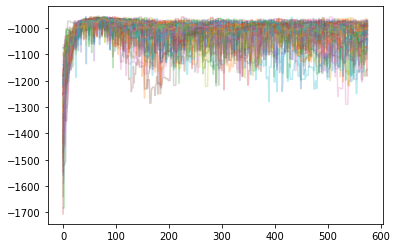

In [64]:
plt.plot(m.weights[25:], alpha=.3);

In [65]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -959.6624583322329
"d1_A": 1.465012,
"d2_A": 2.859472,
"d1_S": 3.928330,
"d2_S": 4.332311,
"A": 0.347587,
"b": 1.821358,
"t0": 0.005216,


/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


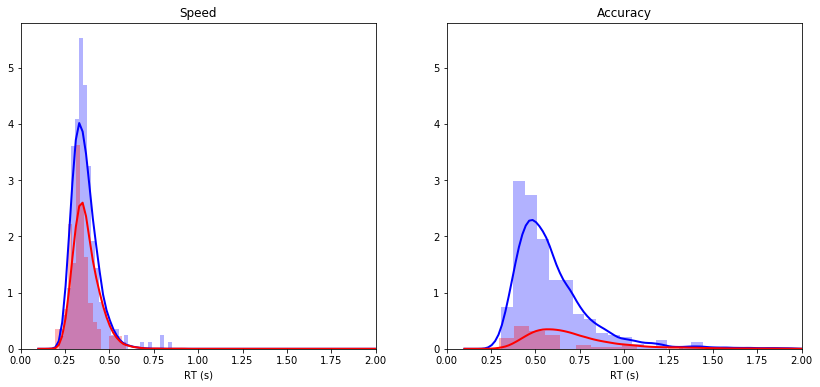

In [66]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [69]:
# save out model to an ArviZ Inference Dataset
daz_d = az.from_dict(**arviz_dict(m, burnin=200))
daz_d.posterior

<xarray.Dataset>
Dimensions:  (chain: 70, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68 69
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    d1_A     (chain, draw) float64 0.9195 0.9195 0.9195 ... 2.091 2.091 2.091
    d2_A     (chain, draw) float64 2.062 2.062 2.062 2.062 ... 3.077 3.077 3.077
    d1_S     (chain, draw) float64 2.938 2.938 2.938 2.938 ... 4.712 4.712 4.712
    d2_S     (chain, draw) float64 3.267 3.267 3.267 3.267 ... 5.25 5.25 5.25
    A        (chain, draw) float64 0.2127 0.2127 0.2127 ... 1.365 1.365 1.365
    b        (chain, draw) float64 1.148 1.148 1.148 1.148 ... 2.59 2.59 2.59
    t0       (chain, draw) float64 0.06094 0.06094 0.06094 ... 0.04845 0.04845
Attributes:
    created_at:  2020-03-05T22:14:14.485860

In [70]:
# do a model comparison
az.compare({'threshold': daz_t, 'drift': daz_d})

/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1213: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  """


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
threshold,0,3855.28,921.181,0,1,3.63233e-11,0,True,deviance
drift,1,5331.12,1699.36,1475.84,3.34977e-321,7.56023e-11,0,True,deviance


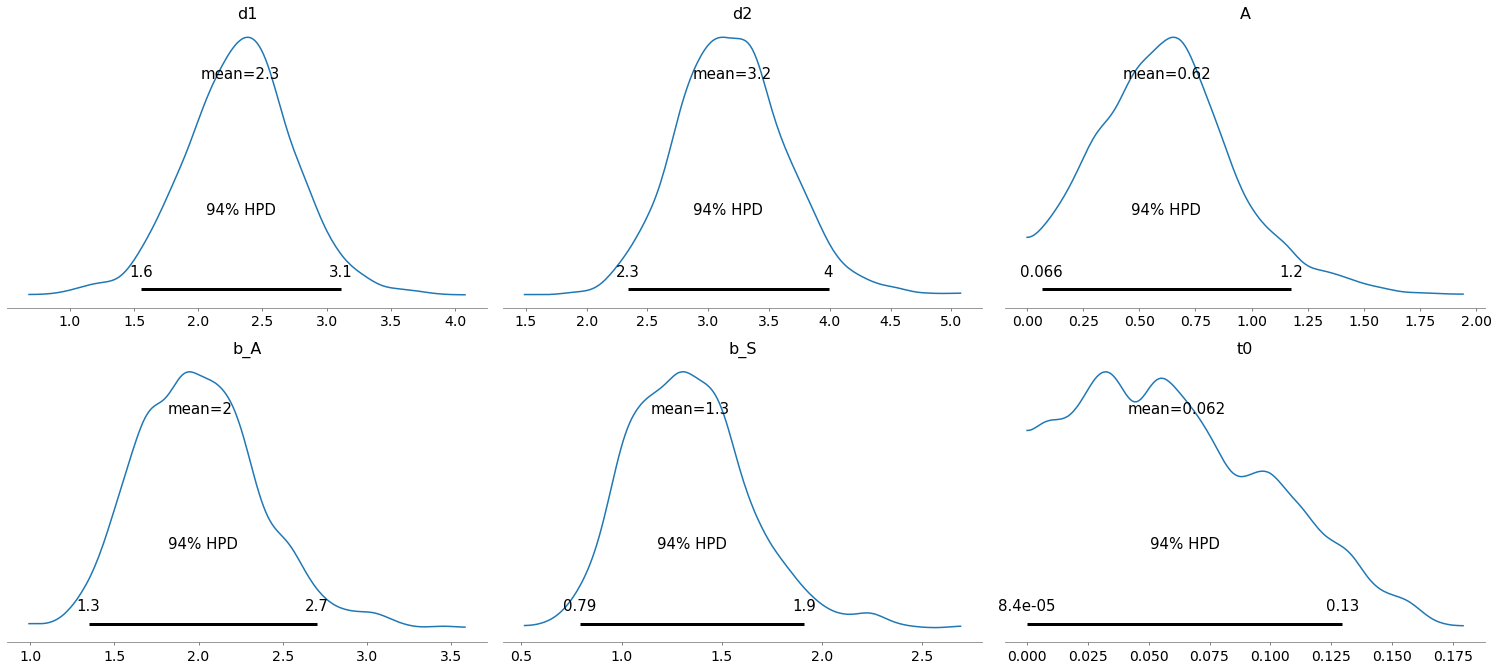

In [72]:
az.plot_posterior(daz_t);

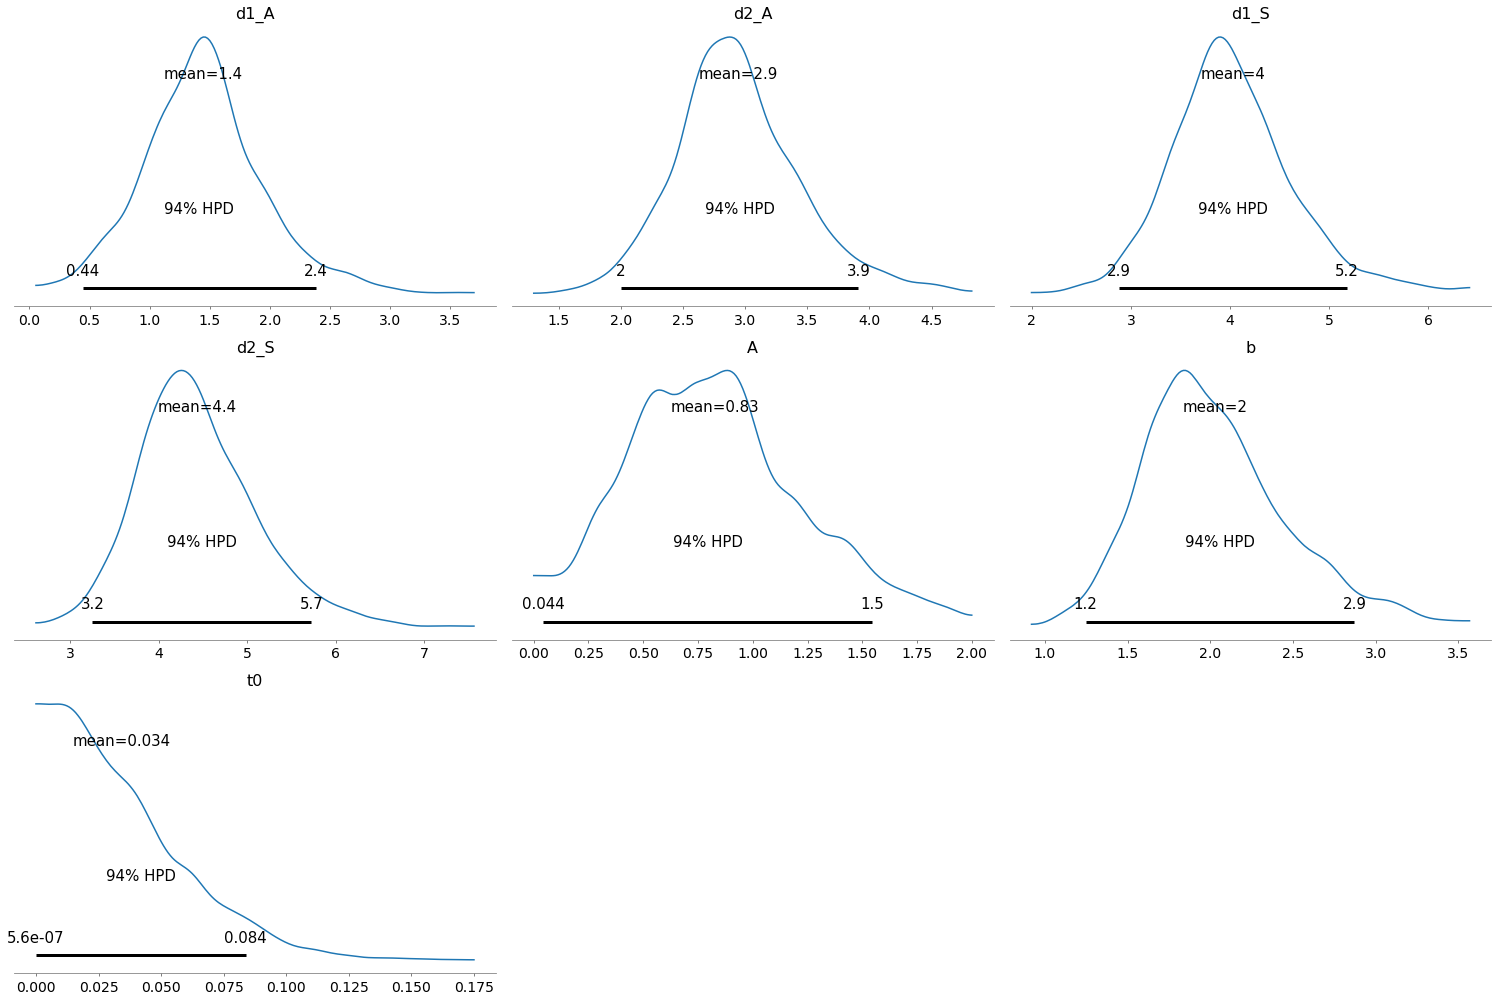

In [73]:
az.plot_posterior(daz_d);

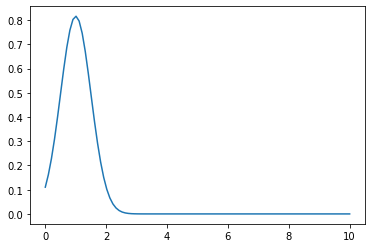

In [76]:
plt.plot(np.linspace(0,10,100), 
         dists.trunc_normal(1., .5, 0., 10.).pdf(np.linspace(0, 10, 100)));

In [117]:
# Test scaling drift rate

# set up the params
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='sS', prior=dists.trunc_normal(1., .5, 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]


# grab the beh data of interest
dat_A = dat[(dat['cond']=='Accuracy')].to_records()
dat_S = dat[(dat['cond']=='Speed')].to_records()

# set up PDA
rt_min = .05
rt_max = 2.1
pda_A = PDA(dat_A, cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)
pda_S = PDA(dat_S, cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)

print(pda_A._lower, pda_A._upper)
print(pda_S._lower, pda_S._upper)

# set up the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b']):# or np.any(p<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        res.loc[res.rt < rt_min, 'correct'] = -1
        likes[i] += pda_A.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
        # then Speed
        res = lba_sim(I=(p['d1']*p['sS'], p['d2']*p['sS']), A=p['A'], S=1.0*p['sS'], b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        res.loc[res.rt < rt_min, 'correct'] = -1
        likes[i] += pda_S.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue

    return likes
        
# make the model
m = Model('decisions3', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          purify_every=5,
          verbose=True)

-27.491212349279863 0.49618599732126356
-16.400884801088214 0.5357425467383643


In [118]:
# do some burnin
times = m.sample(100, burnin=True)

Initializing: 60(60) 13(13) 5(5) Iterations (100): 1 2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


4 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 5 6 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


7 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


8 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


9 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 10 11 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


12 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


13 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


14 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 15 16 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


17 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


18 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


19 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 20 21 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


22 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


23 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


24 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 25 26 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


27 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


28 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


29 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 30 31 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


32 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


33 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


34 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 35 36 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


37 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


38 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


39 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 40 41 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


42 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


43 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


44 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 45 46 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


47 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


48 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


49 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 50 51 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


52 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


53 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


54 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 55 56 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


57 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


58 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


59 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 60 61 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


62 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


63 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


64 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 65 66 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


67 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


68 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


69 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 70 71 72 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


73 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


74 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 75 76 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


77 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


78 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


79 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 80 81 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


82 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


83 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


84 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 85 86 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


87 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


88 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


89 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 90 91 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


92 93 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


94 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 95 96 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


97 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


98 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


99 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 100 


/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


In [101]:
times = m.sample(500, burnin=False)

Iterations (500): 1 2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


4 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 5 6 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


7 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


8 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


9 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 10 11 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


12 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


13 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


14 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 15 16 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


17 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


18 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


19 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 20 21 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


22 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


23 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


24 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 25 26 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


27 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


28 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


29 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 30 31 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


32 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


33 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


34 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 35 36 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


37 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


38 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


39 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 40 41 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


42 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


43 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


44 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 45 46 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


47 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


48 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


49 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 50 51 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


52 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


53 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


54 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 55 56 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


57 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


58 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


59 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 60 61 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


62 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


63 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


64 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 65 66 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


67 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


68 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


69 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 70 71 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


72 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


73 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


74 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 75 76 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


77 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


78 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


79 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 80 81 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


82 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


83 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


84 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 85 86 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


87 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


88 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


89 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 90 91 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


92 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


93 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


94 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 95 96 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


97 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


98 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


99 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 100 101 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


102 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


103 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


104 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 105 106 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


107 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


108 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


109 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 110 111 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


112 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


113 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


114 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 115 116 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


117 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


118 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


119 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 120 121 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


122 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


123 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


124 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 125 126 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


127 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


128 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


129 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 130 131 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


132 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


133 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


134 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 135 136 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


137 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


138 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


139 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 140 141 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


142 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


143 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


144 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 145 146 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


147 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


148 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


149 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 150 151 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


152 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


153 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


154 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 155 156 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


157 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


158 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


159 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 160 161 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


162 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


163 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


164 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 165 166 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


167 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


168 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


169 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 170 171 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


172 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


173 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


174 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 175 176 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


177 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


178 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


179 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 180 181 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


182 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


183 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


184 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 185 186 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


187 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


188 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


189 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 190 191 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


192 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


193 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


194 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 195 196 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


197 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


198 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


199 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 200 201 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


202 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


203 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


204 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 205 206 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


207 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


208 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


209 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 210 211 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


212 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


213 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


214 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 215 216 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


217 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


218 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


219 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 220 221 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


222 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


223 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


224 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 225 226 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


227 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


228 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


229 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 230 231 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


232 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


233 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


234 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 235 236 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


237 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


238 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


239 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 240 241 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


242 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


243 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


244 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 245 246 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


247 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


248 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


249 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 250 251 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


252 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


253 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


254 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 255 256 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


257 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


258 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


259 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 260 261 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


262 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


263 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


264 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 265 266 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


267 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


268 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


269 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 270 271 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


272 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


273 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


274 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 275 276 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


277 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


278 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


279 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 280 281 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


282 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


283 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


284 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 285 286 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


287 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


288 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


289 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 290 291 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


292 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


293 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


294 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 295 296 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


297 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


298 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


299 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 300 301 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


302 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


303 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


304 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 305 306 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


307 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


308 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


309 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 310 311 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


312 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


313 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


314 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 315 316 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


317 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


318 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


319 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 320 321 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


322 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


323 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


324 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 325 326 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


327 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


328 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


329 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 330 331 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


332 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


333 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


334 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 335 336 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


337 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


338 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


339 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 340 341 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


342 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


343 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


344 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 345 346 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


347 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


348 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


349 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 350 351 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


352 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


353 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


354 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 355 356 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


357 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


358 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


359 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 360 361 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


362 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


363 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


364 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 365 366 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


367 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


368 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


369 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 370 371 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


372 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


373 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


374 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 375 376 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


377 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


378 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


379 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 380 381 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


382 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


383 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


384 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 385 386 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


387 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


388 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


389 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 390 391 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


392 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


393 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


394 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 395 396 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


397 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


398 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


399 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 400 401 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


402 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


403 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


404 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 405 406 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


407 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


408 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


409 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 410 411 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


412 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


413 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


414 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 415 416 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


417 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


418 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


419 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 420 421 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


422 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


423 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


424 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 425 426 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


427 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


428 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


429 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 430 431 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


432 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


433 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


434 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 435 436 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


437 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


438 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


439 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 440 441 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


442 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


443 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


444 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 445 446 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


447 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


448 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


449 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 450 451 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


452 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


453 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


454 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 455 456 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


457 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


458 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


459 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 460 461 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


462 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


463 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


464 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 465 466 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


467 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


468 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


469 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 470 471 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


472 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


473 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


474 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 475 476 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


477 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


478 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


479 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 480 481 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


482 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


483 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


484 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 485 486 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


487 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


488 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


489 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 490 491 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


492 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


493 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


494 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 495 496 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


497 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


498 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


499 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))
/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


= 500 


/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


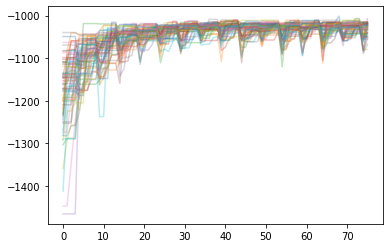

In [119]:
plt.plot(m.weights[25:], alpha=.3);

In [120]:
print("Best fitting params:")
burnin=20
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -1013.2809901799824
"d1": 2.185544,
"d2": 2.850962,
"sS": 1.751708,
"A": 0.582706,
"b": 1.835842,
"t0": 0.071801,


/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


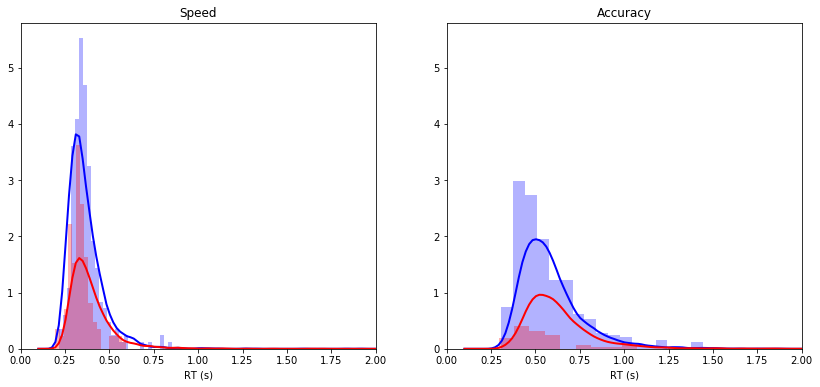

In [121]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

xvals = np.linspace(.1, 2.0, 100)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1']*pp['sS'], pp['d2']*pp['sS']), A=pp['A'], S=1.0*pp['sS'], b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [105]:
# save out model to an ArviZ Inference Dataset
daz_s = az.from_dict(**arviz_dict(m, burnin=200))
daz_s.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    d1       (chain, draw) float64 2.084 2.084 2.084 2.084 ... 2.088 2.088 2.088
    d2       (chain, draw) float64 2.645 2.645 2.645 2.645 ... 2.63 2.63 2.63
    sS       (chain, draw) float64 1.742 1.742 1.742 1.742 ... 1.557 1.557 1.557
    A        (chain, draw) float64 1.051 1.051 1.051 1.051 ... 1.112 1.112 1.112
    b        (chain, draw) float64 1.9 1.9 1.9 1.9 ... 2.028 2.028 2.028 2.028
    t0       (chain, draw) float64 0.0819 0.0819 0.0819 ... 0.03845 0.03845
Attributes:
    created_at:  2020-03-06T13:57:08.166474

In [110]:
# do a model comparison
az.compare({'threshold': daz_t, 'drift': daz_d, 'scale': daz_s}, ic='WAIC')

/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1213: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  """


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
threshold,0,3855.28,921.181,0,1,3.63051e-11,0,True,deviance
scale,1,5147.9,1552.79,1292.63,2.03727e-281,7.56389e-11,0,True,deviance
drift,2,5331.12,1699.36,1475.84,3.34977e-321,3.50421e-12,0,True,deviance


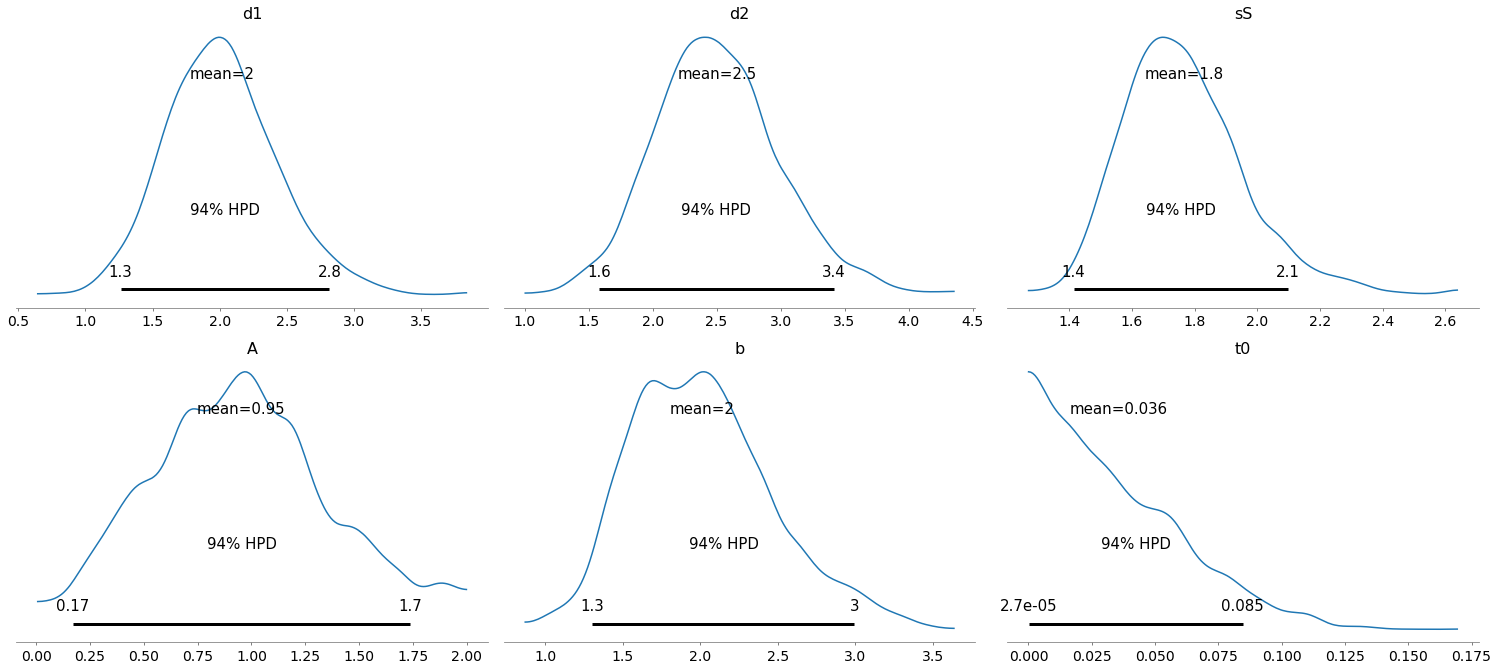

In [107]:
az.plot_posterior(daz_s);